In [1]:

import astropy
import matplotlib
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from matplotlib.colors import LogNorm
from astropy.wcs import WCS
from astropy import wcs
import astropy.wcs
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
import numpy as np
from astropy.coordinates import match_coordinates_sky
from astropy.convolution import Gaussian2DKernel
from scipy.signal import convolve as scipy_convolve
from astropy.convolution import convolve, convolve_fft
from astropy.convolution import interpolate_replace_nans
from astropy.nddata.utils import Cutout2D
import matplotlib.pyplot as mpl
from matplotlib import cm
import matplotlib as mp
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors
import astropy.units as u
from spectral_cube import SpectralCube
from matplotlib.colors import LogNorm
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
import plotly.graph_objects as go
import skimage.measure as measure


In [2]:
filename ='non_pb_corrected_from_dan_G0.068-0.075.H2CO.218.2GHz_subcube_44_77.fits'
h2co_subcube  = fits.open(filename)[0]
h2co_subcube_wcs = WCS(h2co_subcube.header)

filename_int ='non_pb_corrected_from_dan_G0.068-0.075.H2CO.218.2GHz_integrated.fits'
h2co_int  = fits.open(filename_int)[0]
h2co_int_wcs = WCS(h2co_int.header)

In [10]:
x3_filename = "Xray_Clavel_chandra_pigs_cube_smoothed_3k.fits"
x3_hdu      = fits.open(x3_filename)[0]
x3_wcs = WCS(x3_hdu.header)

x4_filename = "Xray_Clavel_chandra_pigs_cube_smoothed_4k_updated_stone_only.fits"
x4_hdu      = fits.open(x4_filename)[0]
x4_wcs = WCS(x4_hdu.header)

h_filename = "data/Herschel_column.fits"
h_hdu      = fits.open(h_filename)[0]
h_wcs = WCS(h_hdu.header)

hcno_filename = get_pkg_data_filename("data/CMZ_3mm_HNCO.fits")
hcno_hdu      = fits.open(hcno_filename)[0]
hcno_wcs = WCS(hcno_hdu.header)


In [7]:
#drop third axis of data cubes

wcs_3xray_2axis=x3_wcs.dropaxis(2)
wcs_4xray_2axis=x4_wcs.dropaxis(2)
wcs_HCNO_2axis=hcno_wcs.dropaxis(2)

In [25]:
# New X-tick method (takes into account position of cloud, equation from Maïca)
# approximate distance ~25 pc
z = []
c = 0.307 # pc/yr (speed of light)
dproj = 12 # pc (distance of cloud) behind the black hole
for t in range(100, 110, 1):
    z.append((1/2)*((c*t) - ((dproj**2)/(c*t)))) 
print(z)
print(z[7] - z[0])
z_diff=[z[1]-z[0], z[2]-z[0], z[3]-z[0], z[4]-z[0], z[5]-z[0], z[6]-z[0], z[7]-z[0]]
print(z_diff)
x_05 = (0.5)*(35/1.228) # x-position corresponding to a distance of 0.5 pc inside the cloud
# print(x_05)
x_1 = (1)*(35/1.228) # x-position corresponding to a distance of 1 pc inside the cloud

x_new_pos = [0, x_05, x_1]
# print(x_new_pos)
x_new_lab = [0, 0.5, 1.228]



[13.004723127035831, 13.181443690134484, 13.357708948074343, 13.533532162170708, 13.708926083688299, 13.883902978129363, 14.058474648147012, 14.232652455173671, 14.40644733984799, 14.579869841317276]
1.22792932813784
[0.17672056309865347, 0.35298582103851217, 0.5288090351348771, 0.7042029566524679, 0.8791798510935322, 1.053751521111181, 1.22792932813784]


0.0
0.176
0.176
0.352
0.352
0.528
0.528
0.528
0.8799999999999999
0.8799999999999999
1.232
1.232
1.408
1.408
1.5839999999999999
1.5839999999999999


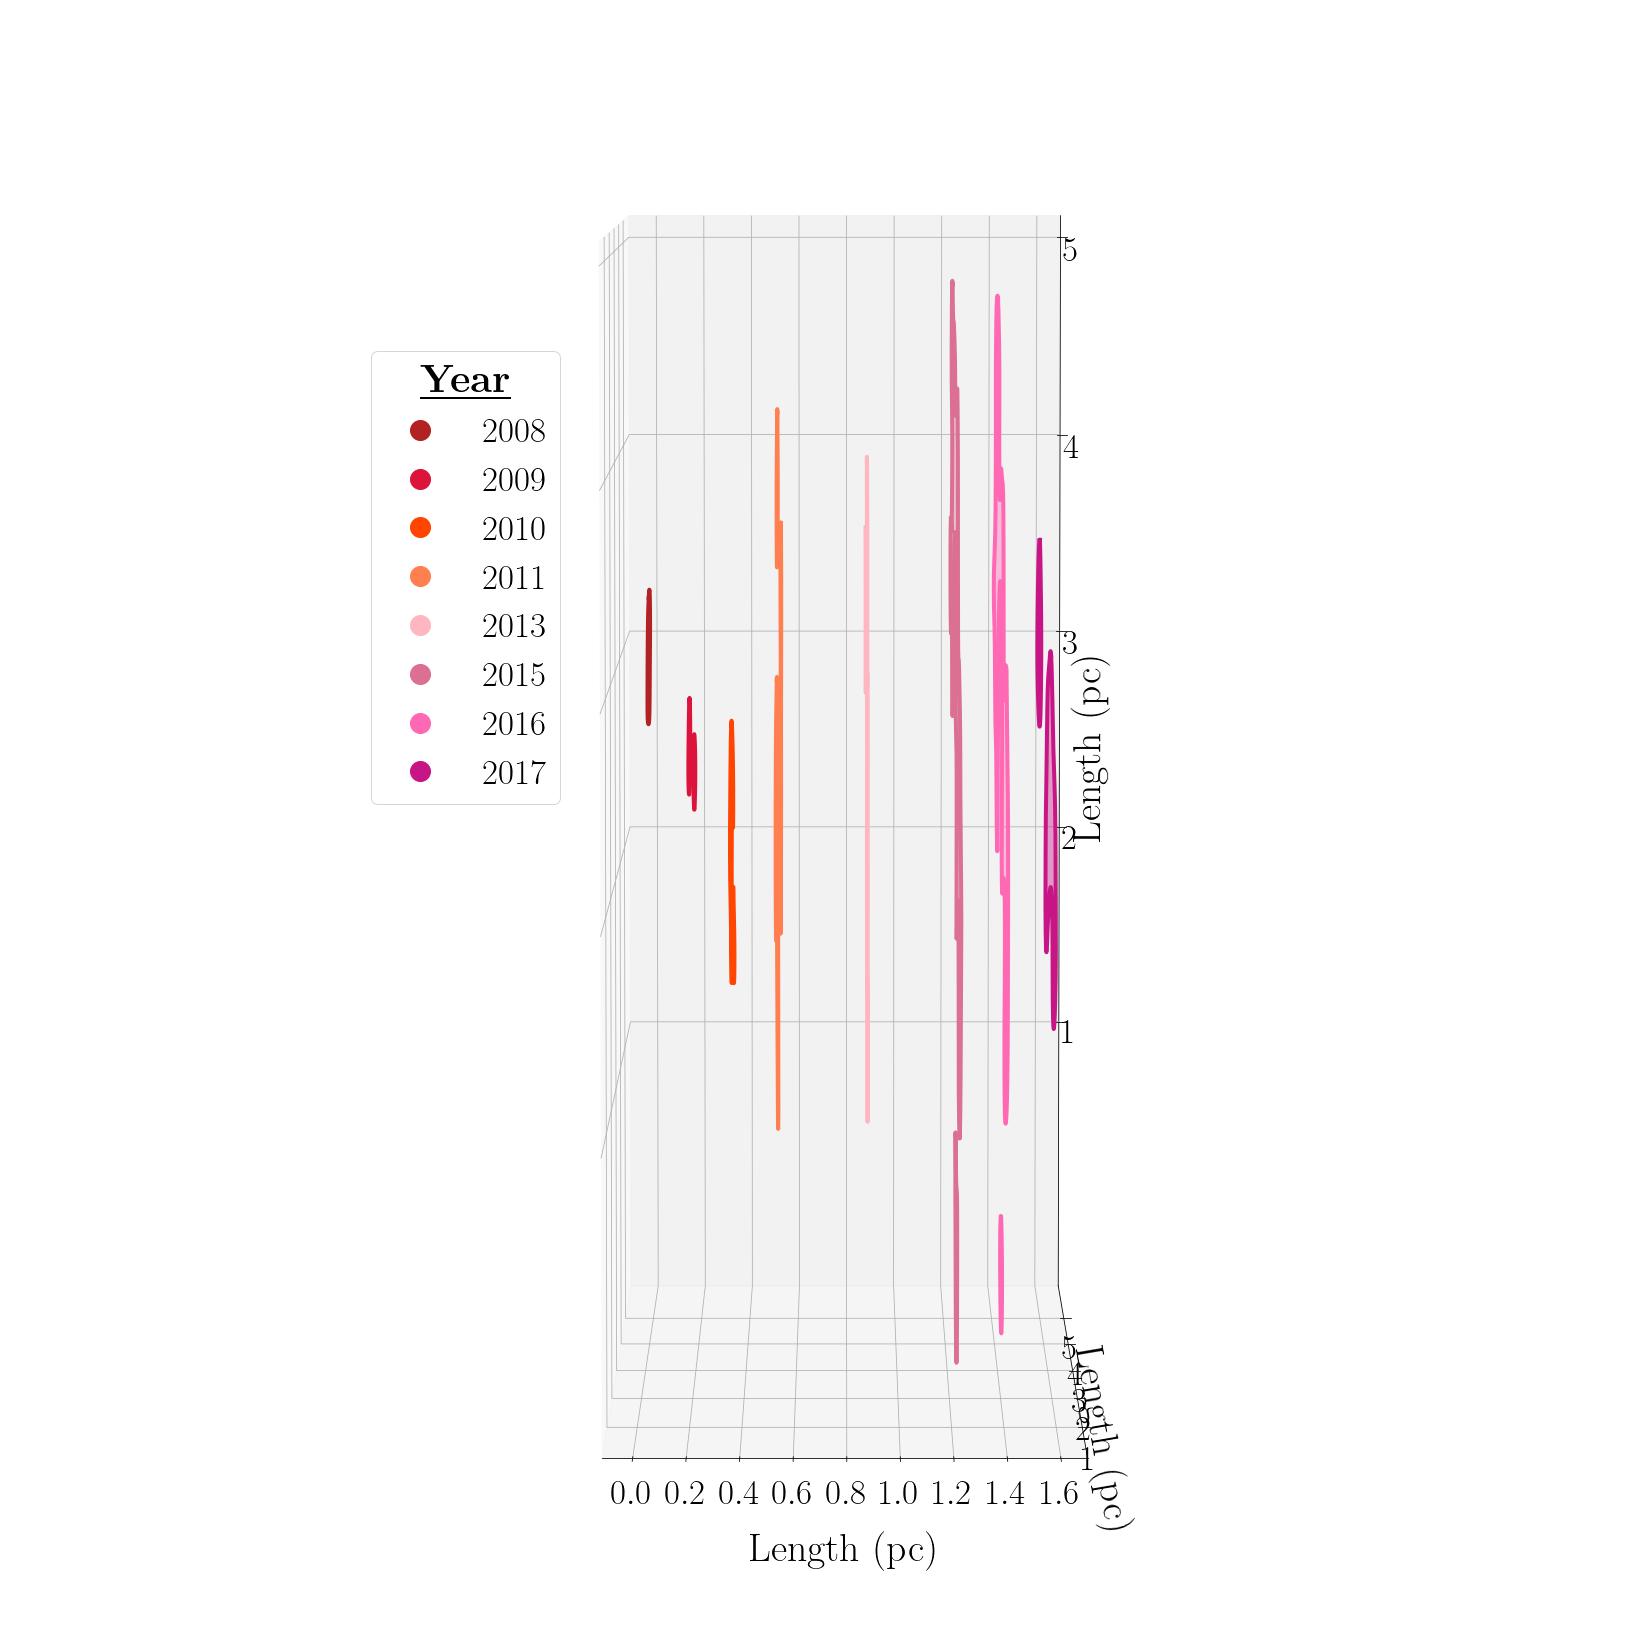

In [29]:
from astropy.visualization.wcsaxes import WCSAxes
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Polygon, PathPatch
import math
import scipy
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Computer Modern'
xray_start_year=2008
xray_start=9
ly_to_pc=0.3066013938
fig = plt.figure(figsize=(30,30))#.add_subplot(projection='3d')
#fig=plt.figure(figsize=(20,15))
ax1=plt.axes(projection='3d')
count=2008
distance = 8178 # (parsecs)
ang = math.degrees(1/distance) # 1 = diameter in pc divided by distance in parsecs
count_list=[]
legend_dict={}

colors=['#6C0832','#A10D4B','#CA195C','#F41D77','#FF5A1D','#FFC11D','#EEE010','#6C0832','#A10D4B']
colors=['#EEE010','#FFC11D','#FF5A1D','#F41D77','#CA195C','#6C0832','#A10D4B','brown','black']
colors=['firebrick', 'crimson', 'orangered', 'coral', 'lightpink', 'palevioletred', 'hotpink', 'mediumvioletred']
for year in range(8):
    contours=measure.find_contours(x4_hdu.data[16-year], 3e-9)
    
    for i in contours:
        if i[0,1]>150 and max(i[:,1])-min(i[:,1])>15:
            lon,lat=wcs_4xray_2axis.wcs_pix2world(i[:, 1],i[:, 0],0)
            p=[]
            y=lat
            x=lon
            for a in range(len(x)):
                p.append((x[a],y[a]))
            
            ax1.plot(x,y , zs=(count-xray_start_year)*.176, zdir='x', linewidth=4, color=colors[year])
            
            P=Polygon(p, color=colors[year], alpha=0.4)
            ax1.add_patch(P)
            art3d.pathpatch_2d_to_3d(P, z=(count-xray_start_year)*.176, zdir='x')
            print((count-xray_start_year)*.176)
        legend_dict[str(count)] = colors[year] # new key, add
    if (count)==2011 or (count)==2013:
        count+=2
    else:
        count+=1



#ax.set_ylabel('Galactic Longitude (Degrees)',size=30,labelpad=30)
ax1.set_xlabel('Length (pc)',size=40,labelpad=35)
ax1.set_ylabel('Length (pc)',size=40,labelpad=35)
ax1.set_zlabel('Length (pc)',size=40,labelpad=45)
#ax.set_zlabel('Galactic Latitude (Degrees)',size=30,labelpad=35)


#start of sams code
distance = 8178 # (parsecs)
ang = math.degrees(1/distance) # 1 = diameter in pc divided by distance in parsecs
# print(ang)
# y_ticks = [0.095, 0.100, 0.105, 0.110, 0.115, 0.120]
# z_ticks = [-0.090, -0.085, -0.080, -0.075, -0.070, -0.065, -0.060]
# x_ticks = [0,5,10,15,20,25,30,35]
y_ticks=[]
z_ticks = []
for i in range(1, 6, 1):
    y_ticks.append(0.043 + (i*ang))
# print(y_ticks)
ytpc = [1, 2, 3, 4, 5]
for i in range(1, 6, 1):
    z_ticks.append(-0.095 + (i*ang))
# print(z_ticks)
ztpc = [1, 2, 3, 4, 5]

ax1.set_yticks(y_ticks)
ax1.set_yticklabels(ytpc)
ax1.set_zticks(z_ticks)
ax1.set_zticklabels(ztpc)

#ax1.set_xticks(x_new_pos) #x_ticks)
#ax1.set_xticklabels(x_new_lab) #xtpc)

ax1.xaxis.set_tick_params(labelsize=35,pad=5)
ax1.yaxis.set_tick_params(labelsize=35,pad=5)
ax1.zaxis.set_tick_params(labelsize=35,pad=15)
ax1.set_box_aspect(aspect = (.4,1,1))
ax1.elev=5
ax1.azim=-90


markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='',markersize=20) for color in legend_dict.values()]
plt.legend(markers, legend_dict.keys(),bbox_to_anchor=(.35,0.8), title=r'\textbf{\underline{Year}}', title_fontsize=40,fontsize=35)#bbox_to_anchor=(0.4, 0.25, 0.5, 0.5)

plt.show()
#ax1.get_proj = lambda: np.dot(Axes3D.get_proj(ax1), np.diag([0.5, 1, 1, 1]))
#ax2=ax1.twiny()
#distances=[]
#for i in range(len(count_list)):
    #distances.append((count_list[i]-1999)*ly_to_pc)
#ax2.set_xticks(distances)
#ax2.set_xlabel('Distance (pc)',size=12)
#ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: parsecs_formatter(ang_size * distance, pos)))
#ax1.yaxis.set_minor_formatter(FuncFormatter(lambda x, pos: parsecs_formatter(ang_size * distance, pos)))


In [62]:
# New X-tick method (takes into account position of cloud, equation from Maïca)
# approximate distance ~25 pc
z = []
c = 0.307 # pc/yr (speed of light)
dproj = 20 # pc (distance of cloud)
for t in range(141, 151, 1):
    z.append((1/2)*((c*t) - ((dproj**2)/(c*t))))
print(z)

print(z[-1]-z[0],z[2]-z[1])

[17.02317519116594, 17.2092126898197, 17.394795118562218, 17.579931958016648, 17.764632427271707, 17.94890549283834, 18.132759877240797, 18.31620406725944, 18.499246321841596, 18.68189467969598]
1.6587194885300391 0.18558242874251718


1.674
1.488
1.488
1.302
1.302
1.116
1.116
1.116
0.9299999999999999
0.9299999999999999
0.558
0.558
0.186
0.186
0.0
0.0


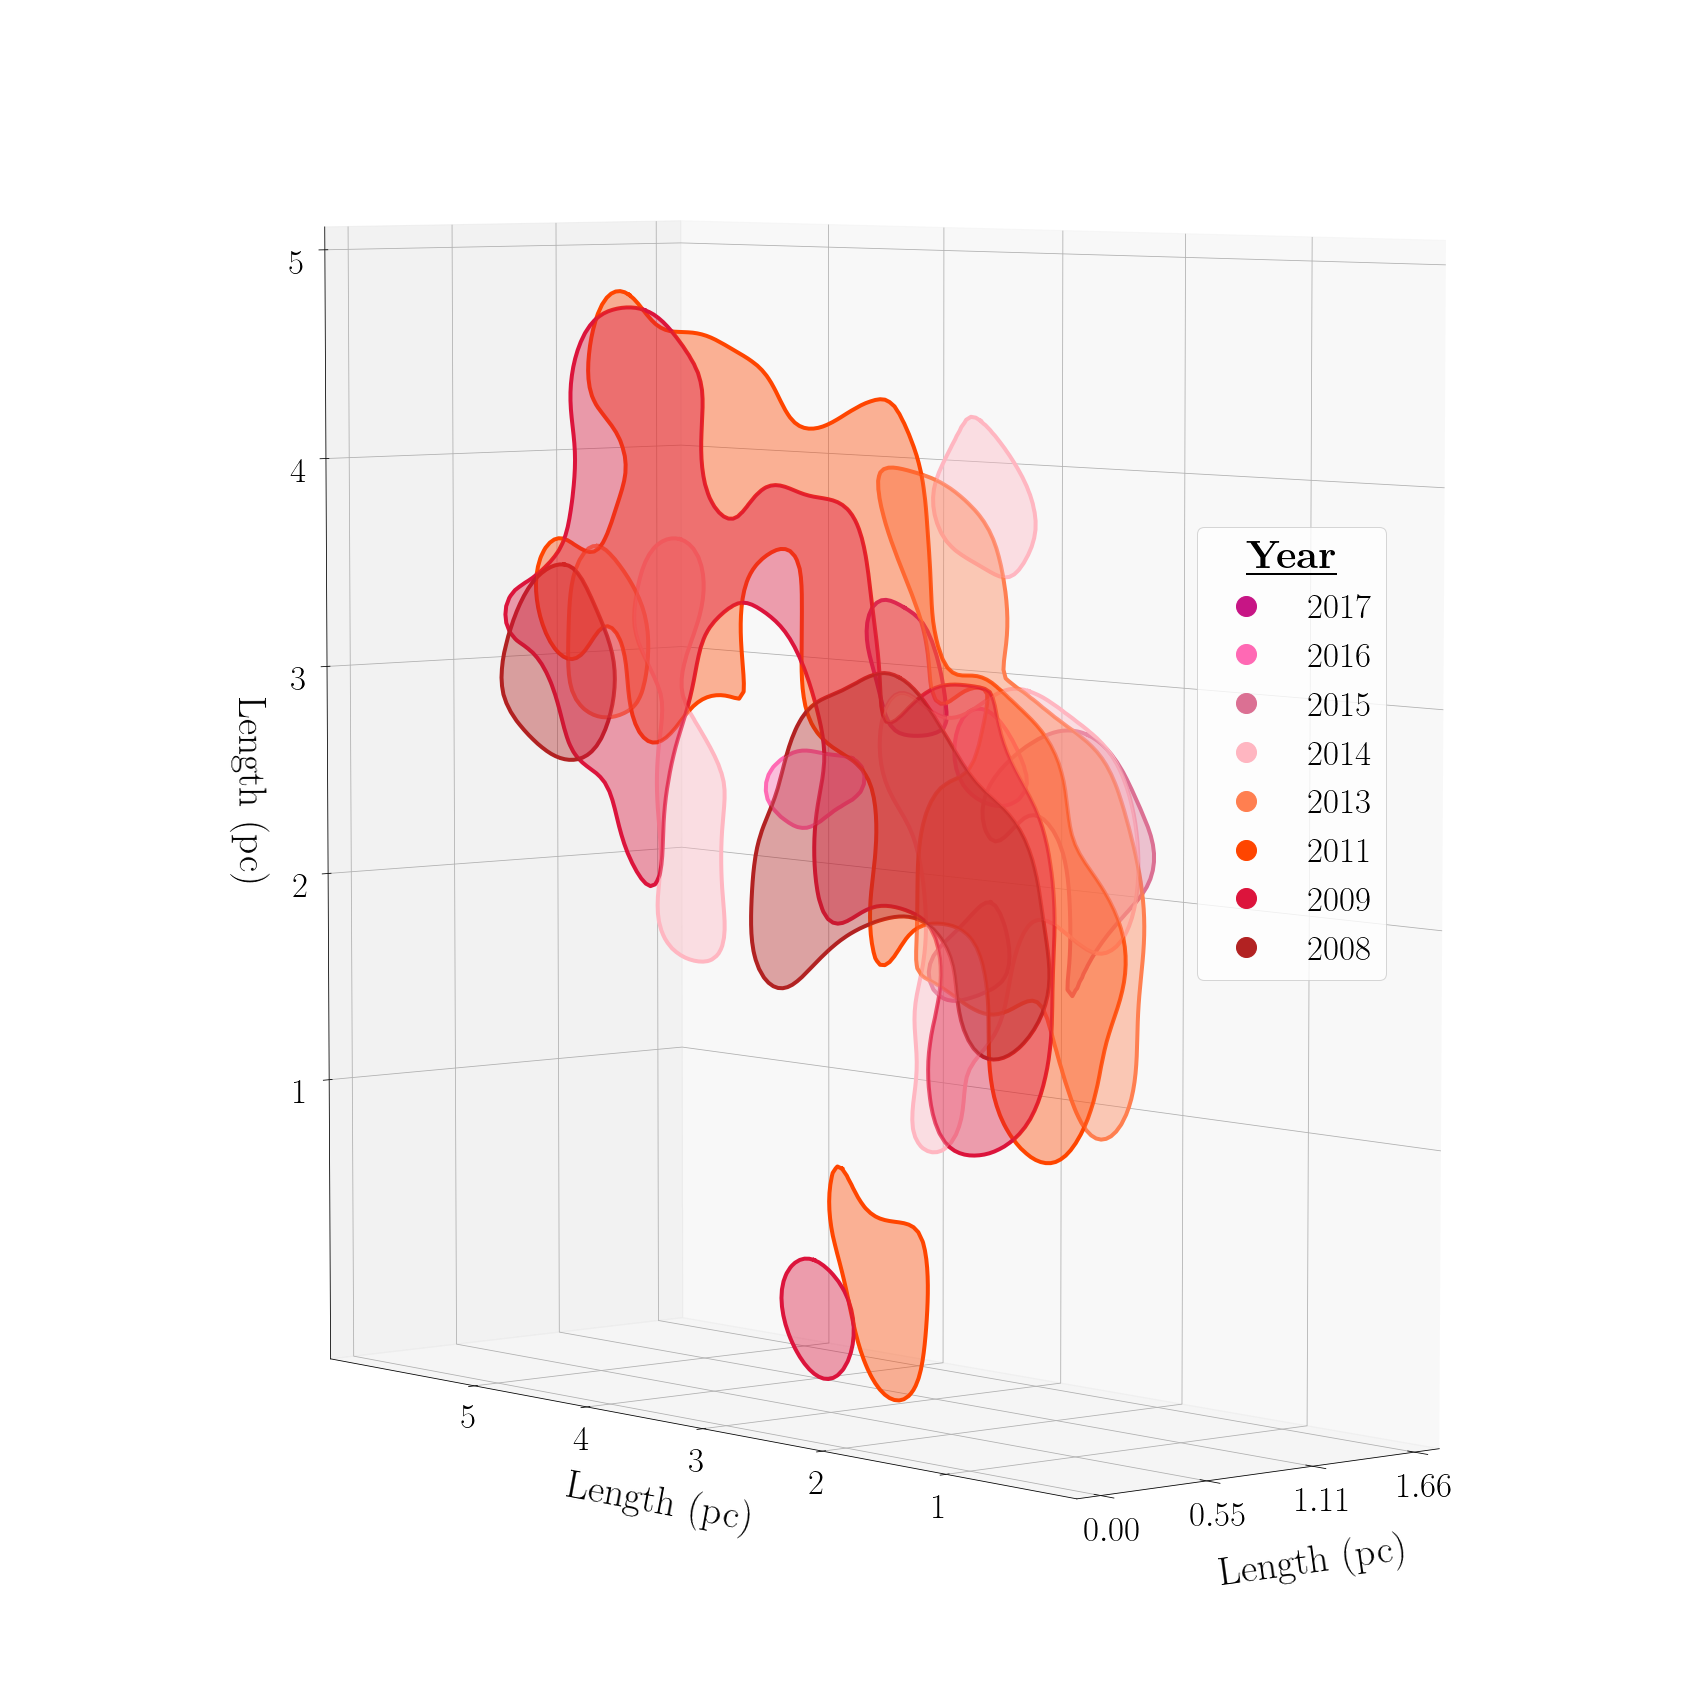

In [70]:
from astropy.visualization.wcsaxes import WCSAxes
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Polygon, PathPatch
import math
import scipy
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Computer Modern'
xray_start_year=2008
xray_start=9
ly_to_pc=0.3066013938
fig = plt.figure(figsize=(30,50))#.add_subplot(projection='3d')
#fig=plt.figure(figsize=(20,15))
ax1=plt.axes(projection='3d')
count=2017
distance = 8178 # (parsecs)
ang = math.degrees(1/distance) # 1 = diameter in pc divided by distance in parsecs
count_list=[]
legend_dict={}

colors=['firebrick', 'crimson', 'orangered', 'coral', 'lightpink', 'palevioletred', 'hotpink', 'mediumvioletred']

for year in range(8):
    contours=measure.find_contours(x4_hdu.data[16-year], 3e-9)
    
    for i in contours:
        if i[0,1]>150 and max(i[:,1])-min(i[:,1])>15:
            lon,lat=wcs_4xray_2axis.wcs_pix2world(i[:, 1],i[:, 0],0)
            p=[]
            y=lat
            x=lon
            for a in range(len(x)):
                p.append((x[a],y[a]))
            
            ax1.plot(x,y , zs=(count-xray_start_year)*.186, zdir='x', linewidth=4, color=colors[7-year])
            
            P=Polygon(p, color=colors[7-year], alpha=0.4)
            ax1.add_patch(P)
            art3d.pathpatch_2d_to_3d(P, z=(count-xray_start_year)*.186, zdir='x')
            print((count-xray_start_year)*.186)
        legend_dict[str(count)] = colors[7-year] # new key, add
    if (count)==2011 or (count)==2013:
        count-=2
    else:
        count-=1



#ax.set_ylabel('Galactic Longitude (Degrees)',size=30,labelpad=30)
ax1.set_xlabel('Length (pc)',size=40,labelpad=35)
ax1.set_ylabel('Length (pc)',size=40,labelpad=35)
ax1.set_zlabel('Length (pc)',size=40,labelpad=45)
#ax.set_zlabel('Galactic Latitude (Degrees)',size=30,labelpad=35)


#start of sams code
distance = 8178 # (parsecs)
ang = math.degrees(1/distance) # 1 = diameter in pc divided by distance in parsecs
# print(ang)
# y_ticks = [0.095, 0.100, 0.105, 0.110, 0.115, 0.120]
# z_ticks = [-0.090, -0.085, -0.080, -0.075, -0.070, -0.065, -0.060]
# x_ticks = [0,5,10,15,20,25,30,35]
y_ticks=[]
z_ticks = []
for i in range(1, 6, 1):
    y_ticks.append(0.043 + (i*ang))
# print(y_ticks)
ytpc = [1, 2, 3, 4, 5]
for i in range(1, 6, 1):
    z_ticks.append(-0.095 + (i*ang))
# print(z_ticks)
ztpc = [1, 2, 3, 4, 5]

ax1.set_yticks(y_ticks)
ax1.set_yticklabels(ytpc)
ax1.set_zticks(z_ticks)
ax1.set_zticklabels(ztpc)

#ax1.set_xticks(x_new_pos) #x_ticks)
#ax1.set_xticklabels(x_new_lab) #xtpc)

ax1.xaxis.set_tick_params(labelsize=35,pad=5)
ax1.yaxis.set_tick_params(labelsize=35,pad=5)
ax1.zaxis.set_tick_params(labelsize=35,pad=15)
ax1.set_box_aspect(aspect = (.4,1,1))
ax1.elev=5
ax1.azim=-130
#ax1.set_title('140 Year Old Event',fontsize=60)
x = np.round(np.linspace(0, z[-1]-z[0], 4),2)
ax1.set_xticks((x))

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='',markersize=20) for color in legend_dict.values()]
plt.legend(markers, legend_dict.keys(),bbox_to_anchor=(.70,0.7), title=r'\textbf{\underline{Year}}', title_fontsize=40,fontsize=35)#bbox_to_anchor=(0.4, 0.25, 0.5, 0.5)
plt.show()
#ax1.get_proj = lambda: np.dot(Axes3D.get_proj(ax1), np.diag([0.5, 1, 1, 1]))
#ax2=ax1.twiny()
#distances=[]
#for i in range(len(count_list)):
    #distances.append((count_list[i]-1999)*ly_to_pc)
#ax2.set_xticks(distances)
#ax2.set_xlabel('Distance (pc)',size=12)
#ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: parsecs_formatter(ang_size * distance, pos)))
#ax1.yaxis.set_minor_formatter(FuncFormatter(lambda x, pos: parsecs_formatter(ang_size * distance, pos)))


In [71]:
fig.savefig('stone3d_3e9_100year_event.pdf',bbox_inches='tight')